In [40]:
import pandas as pd
import itertools

# File path to load

In [41]:
file_path = 'transactions_with_parents.csv'

 # Parameters

In [42]:
IS_PRINT_ = False
MIN_SUP = 140
MIN_CONF = 0.3

# Apriori algorithm


In [50]:
class AprioriAlgorithm:
    def __init__(self, min_support, min_confidence):
        self.min_support = min_support
        self.min_confidence = min_confidence
        self.df_transaction_dataset = None
        self.frequent_itemsets = {}
        self.transactions_taxonomy_elements_frequency = None

    def load_data(self, file_path,size=2000):
        self.df_transaction_dataset = pd.read_csv(file_path)
        self.df_transaction_dataset = self.df_transaction_dataset.head(size)

    ########################################
    # Frequency Counting
    ########################################
    def frequency_counting(self):
        item_counts = self.df_transaction_dataset[[col for col in self.df_transaction_dataset.columns if col.isdigit() and len(col) == 4]].sum()
        unique_combinations = set()
        combination_counts = {}

        for index, row in self.df_transaction_dataset.iterrows():
            for col in self.df_transaction_dataset.columns:
                if col.isdigit() and len(col) == 3:
                    value = row[col]
                    if value != 0:
                        combination_key = (col, value)
                        if combination_key in unique_combinations:
                            combination_counts[combination_key] += 1
                        else:
                            unique_combinations.add(combination_key)
                            combination_counts[combination_key] = 1

        combination_counts_series = pd.Series(combination_counts)
        transactions_taxonomy_elements_frequency = pd.concat([item_counts, combination_counts_series])

        return transactions_taxonomy_elements_frequency


    ########################################
    # Generate Frequent k-itemsets
    ########################################
    def generate_candidates(self, prev_itemsets, k):
        candidates = set()
        for itemset1 in prev_itemsets:
            for itemset2 in prev_itemsets:
                if len(itemset1.union(itemset2)) == k:
                    candidates.add(itemset1.union(itemset2))
        return candidates

    def prune_itemsets(self, itemsets, rejected_itemsets):
        pruned_itemsets = {}
        if rejected_itemsets:
            itemsets = set(itemset for itemset in itemsets if itemset not in rejected_itemsets)
        for itemset in itemsets:
            support = sum(
                all(
                    (item[0] in row and row[item[0]] == item[1])
                    if isinstance(item, tuple)
                    else (item in row and row[item] != 0)
                    for item in itemset
                )
                for _, row in self.df_transaction_dataset.iterrows()
            )
            if support >= self.min_support:
                pruned_itemsets[itemset] = support
            else:
                rejected_itemsets.add(itemset)
        return pruned_itemsets

    def generate_frequent_itemsets(self):
        frequent_1_itemsets = {}
        rejected_itemsets = set()

        for item, count in self.transactions_taxonomy_elements_frequency.items():
            if count >= self.min_support:
                frequent_1_itemsets[frozenset([item])] = count

        self.frequent_itemsets[1] = frequent_1_itemsets

        k = 2
        while self.frequent_itemsets[k - 1]:
            candidate_itemsets = self.generate_candidates(self.frequent_itemsets[k - 1].keys(), k)
            pruned_itemsets = self.prune_itemsets(candidate_itemsets, rejected_itemsets)
            self.frequent_itemsets[k] = pruned_itemsets
            k += 1

    ########################################
    # Generate Association Rules
    ########################################
    def generate_association_rules(self):
        association_rules = []

        if len(self.frequent_itemsets) < 2:
            return association_rules

        frequent_itemsets_to_create_rules = self.frequent_itemsets.get(len(self.frequent_itemsets) - 2)

        if frequent_itemsets_to_create_rules is None:
            return association_rules

        for itemset in frequent_itemsets_to_create_rules.items():
            support_without_tuple = itemset[1]
            itemset = itemset[0]
            new_itemset = True
            last_support_for_tuple = None
            subsets = self.get_subsets(itemset)

            for subset in subsets:
                antecedent = subset
                consequent = itemset - subset
                if len(antecedent) >= 2 or isinstance(antecedent, tuple) or any(isinstance(x, tuple) for x in consequent):
                    antecedent_support = sum(
                        all(
                            (row[item[0]] > item[1])
                            if isinstance(item, tuple)
                            else (row[item] == 1)
                            for item in antecedent
                        )
                        for _, row in self.df_transaction_dataset.iterrows()
                    )

                    if new_itemset:
                        new_itemset = False
                        base_support = sum(
                            all(
                                (row[item[0]] > item[1])
                                if isinstance(item, tuple)
                                else (row[item] == 1)
                                for item in itemset
                            )
                            for _, row in self.df_transaction_dataset.iterrows()
                        )

                        last_support_for_tuple = base_support
                    support = last_support_for_tuple
                    if antecedent_support > 0:
                        confidence = support / antecedent_support
                        if confidence >= self.min_confidence:
                            association_rules.append((antecedent, consequent, support, confidence))
                else:
                    antecedent_support = self.frequent_itemsets[len(antecedent)][antecedent]
                    confidence = support_without_tuple / antecedent_support
                    if confidence >= self.min_confidence:
                        association_rules.append((antecedent, consequent, support_without_tuple, confidence))

        return association_rules

    def get_subsets(self, itemset):
        subsets = []
        itemset = list(itemset)
        num_items = len(itemset)

        for i in range(1, num_items):
            subsets.extend(itertools.combinations(itemset, i))

        return [frozenset(subset) for subset in subsets]

    def run_algorithm(self, file_path,dataset_size=2000):
        self.load_data(file_path,dataset_size)
        self.transactions_taxonomy_elements_frequency = self.frequency_counting()
        self.generate_frequent_itemsets()
        association_rules = self.generate_association_rules()
        return self.transactions_taxonomy_elements_frequency, association_rules

In [48]:
class AprioriAlgorithmRunner:
    def __init__(self, min_support, min_confidence):
        self.apriori_algorithm = AprioriAlgorithm(min_support, min_confidence)

    def run_algorithm(self, file_path, dataset_size=2000):
        return self.apriori_algorithm.run_algorithm(file_path, dataset_size)

# Run algorithm

In [34]:
runner = AprioriAlgorithmRunner(min_support=MIN_SUP, min_confidence=MIN_CONF)
transactions_taxonomy_elements_frequency, association_rules = runner.run_algorithm(file_path=file_path,dataset_size = 5000)

In [35]:
print("Frequency Counting Results:")
print(transactions_taxonomy_elements_frequency)

Frequency Counting Results:
1001          19
1002         175
1003           2
1004           8
1005          47
            ... 
(100, 14)      1
(132, 3)       1
(213, 1)       4
(130, 6)       1
(303, 3)       1
Length: 1394, dtype: int64


In [36]:
print("\nAssociation Rules:")
for antecedent, consequent, support, confidence in association_rules:
    antecedent_str = ', '.join([str(item) for item in antecedent])
    consequent_str = ', '.join([str(item) for item in consequent])
    print(f"Antecedent: {antecedent_str}, Consequent: {consequent_str}, Support: {support}, Confidence: {confidence}")


Association Rules:
Antecedent: ('132', 1), Consequent: ('130', 1), ('100', 2), ('150', 1), Support: 28, Confidence: 0.5384615384615384
Antecedent: ('132', 1), ('150', 1), Consequent: ('130', 1), ('100', 2), Support: 28, Confidence: 1.0
Antecedent: ('130', 1), ('132', 1), Consequent: ('100', 2), ('150', 1), Support: 28, Confidence: 0.5384615384615384
Antecedent: ('100', 2), ('132', 1), Consequent: ('130', 1), ('150', 1), Support: 28, Confidence: 0.6363636363636364
Antecedent: ('130', 1), ('132', 1), ('150', 1), Consequent: ('100', 2), Support: 28, Confidence: 1.0
Antecedent: ('100', 2), ('132', 1), ('150', 1), Consequent: ('130', 1), Support: 28, Confidence: 1.0
Antecedent: ('130', 1), ('100', 2), ('132', 1), Consequent: ('150', 1), Support: 28, Confidence: 0.6363636363636364
Antecedent: ('154', 1), Consequent: 1113, ('100', 1), ('150', 1), Support: 17, Confidence: 0.7727272727272727
Antecedent: 1113, ('154', 1), Consequent: ('100', 1), ('150', 1), Support: 17, Confidence: 1.0
Antecede

# Eksperymenty

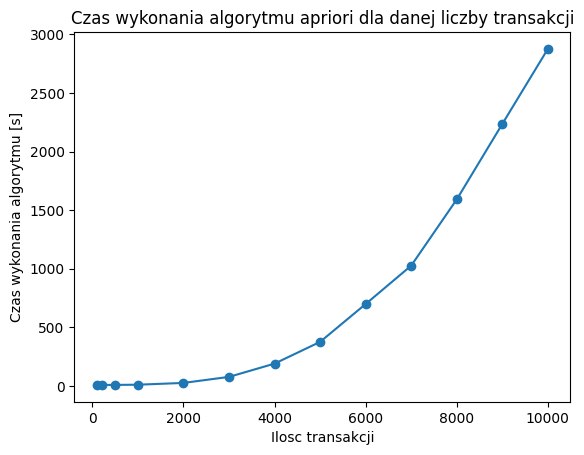

In [59]:
import time
import matplotlib.pyplot as plt
import pandas as pd

dataset_sizes = [100, 200, 500, 1000, 2000, 3000,4000,5000,6000,7000,8000,9000,10000]
MIN_SUP = 140
MIN_CONF = 0.3
execution_times = []
rule_data = []

for size in dataset_sizes:
    runner = AprioriAlgorithmRunner(min_support=MIN_SUP, min_confidence=MIN_CONF)
    start_time = time.time()
    transactions_taxonomy_elements_frequency, association_rules = runner.run_algorithm(file_path=file_path, dataset_size=size)
    end_time = time.time()
    execution_time = end_time - start_time
    execution_times.append(execution_time)

    # Save rules and frequencies in a dictionary
    rule_data.append({
        'Dataset Size': size,
        'Transactions Taxonomy Elements Frequency': transactions_taxonomy_elements_frequency,
        'Association Rules': association_rules
    })

# Convert rule_data to a DataFrame
rule_df_140_03 = pd.DataFrame(rule_data)

# Plotting the execution times
plt.plot(dataset_sizes, execution_times, marker='o')
plt.xlabel('Ilosc transakcji')
plt.ylabel('Czas wykonania algorytmu [s]')
plt.title('Czas wykonania algorytmu apriori dla danej liczby transakcji')
plt.show()

In [60]:
rule_df_140_03

,Dataset Size,Transactions Taxonomy Elements Frequency,Association Rules
0,100,1001 5 1002 11 1003 2 1...,[]
1,200,1001 5 1002 15 1003 2 1...,[]
2,500,1001 5 1002 29 1003 ...,[]
3,1000,1001 6 1002 42 1003 ...,"[((('210', 1)), (2010), 185, 0.804347826086956..."
4,2000,1001 12 1002 79 1003 2 1...,"[((('150', 1)), (('200', 1)), 156, 0.349775784..."
5,3000,1001 19 1002 126 1003 ...,"[((('210', 1)), (2010, ('200', 1)), 42, 0.75),..."
6,4000,1001 19 1002 156 1003 ...,"[((('210', 1), ('230', 1)), (('200', 2), 2010)..."
7,5000,1001 19 1002 175 1003 ...,"[((('132', 1)), (('130', 1), ('100', 2), ('150..."
8,6000,1001 19 1002 192 1003 ...,"[((('154', 1)), (1113, ('100', 1), ('150', 1))..."
9,7000,1001 19 1002 236 1003 ...,"[((('154', 1)), (1113, ('100', 1), ('150', 1))..."


In [61]:
rule_df_140_03['Transactions Taxonomy Elements Frequency'][5]

1001          19
1002         126
1003           2
1004           2
1005          26
            ... 
(200, 20)      1
(200, 7)       1
(303, 2)       3
(307, 1)       3
(302, 3)       1
Length: 1382, dtype: int64

In [62]:
rule_df_140_03['Transactions Taxonomy Elements Frequency'][9]

1001          19
1002         236
1003           2
1004          10
1005          65
            ... 
(150, 12)      1
(100, 17)      1
(231, 3)       1
(240, 2)       1
(120, 3)       1
Length: 1407, dtype: int64

In [ ]:
dataset_sizes = [100, 200, 500, 1000, 2000, 3000,4000,6000,8000,10000]
MIN_SUP_2 = 240
MIN_CONF_2 = 0.5
execution_times_2 = []
rule_data_2 = []

for size in dataset_sizes:
    runner = AprioriAlgorithmRunner(min_support=MIN_SUP_2, min_confidence=MIN_CONF_2)
    start_time = time.time()
    transactions_taxonomy_elements_frequency, association_rules = runner.run_algorithm(file_path=file_path, dataset_size=size)
    end_time = time.time()
    execution_time = end_time - start_time
    execution_times_2.append(execution_time)

    # Save rules and frequencies in a dictionary
    rule_data_2.append({
        'Dataset Size': size,
        'Transactions Taxonomy Elements Frequency': transactions_taxonomy_elements_frequency,
        'Association Rules': association_rules
    })
    print('Skonczono szukanie reguł dla zbioru:', str(size))

# Convert rule_data to a DataFrame
rule_df_240_05 = pd.DataFrame(rule_data_2)

# Plotting the execution times
plt.plot(dataset_sizes, execution_times_2, marker='o')
plt.xlabel('Ilosc transakcji')
plt.ylabel('Czas wykonania algorytmu [s]')
plt.title('Czas wykonania algorytmu apriori dla danej liczby transakcji, min_sup = 240, min_conf = 0.5')
plt.show()